In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense
import datetime
import os
import tensorflow as tf

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load the data
file_path = 'Tether_to_IDR_Conversion.xlsx'
data = pd.read_excel(file_path)

# Convert date to datetime format
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')
data.set_index('Tanggal', inplace=True)

# Ensure the data is sorted by date
data = data.sort_index()

# Display the first few rows of the data
display(data.head())


,Terakhir_IDR,Pembukaan_IDR,Tertinggi_IDR,Terendah_IDR
Tanggal,,,,
2024-04-24,16084.993428,16093.039143,16094.648286,16076.947713
2024-04-25,16089.820857,16084.993428,16093.039143,16081.775142
2024-04-26,16089.820857,16089.820857,16094.648286,16084.993428
2024-04-27,16084.993428,16089.820857,16093.039143,16083.384285
2024-04-28,16088.211714,16084.993428,16089.820857,16083.384285


,Terakhir_IDR,SMA,LMA
Tanggal,,,
2024-04-24,16084.993428,16084.993428,16084.993428
2024-04-25,16089.820857,16087.407143,16087.407143
2024-04-26,16089.820857,16088.211714,16088.211714
2024-04-27,16084.993428,16087.407143,16087.407143
2024-04-28,16088.211714,16087.568057,16087.568057
2024-04-29,16088.211714,16088.211714,16087.675333
2024-04-30,16080.165999,16086.280742,16086.602571
2024-05-01,16080.165999,16084.349771,16085.798000
2024-05-02,16097.866572,16086.924400,16087.138952


,Terakhir_IDR,Pembukaan_IDR,Tertinggi_IDR,Terendah_IDR,SMA,LMA,DMA_Prediction,Difference,Percentage_Difference
2024-05-20,16093.039143,16089.820857,16101.084858,16089.820857,16093.682800,16093.039143,16093.682800,-0.643657,-0.004000
2024-05-21,16088.211714,16093.039143,16094.648286,16081.775142,16092.717314,16093.441429,16092.717314,-4.505600,-0.028006
2024-05-22,16083.384285,16088.211714,16091.430000,16083.384285,16089.820857,16092.717314,16089.820857,-6.436572,-0.040020
2024-05-23,16084.993428,16083.384285,16088.211714,16073.729427,16087.889885,16091.832286,16087.889885,-2.896457,-0.018007
2024-05-24,16083.384285,16084.993428,16089.820857,16080.165999,16086.602571,16091.269086,16086.602571,-3.218286,-0.020010
2024-05-25,NaN,NaN,NaN,NaN,NaN,NaN,16089.552666,NaN,NaN
2024-05-26,NaN,NaN,NaN,NaN,NaN,NaN,16089.355993,NaN,NaN
2024-05-27,NaN,NaN,NaN,NaN,NaN,NaN,16088.762994,NaN,NaN
2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN,16088.487851,NaN,NaN
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,16088.541655,NaN,NaN


<Axes: title={'center': 'Prediksi DMA USDT dengan Harga Asli'}>

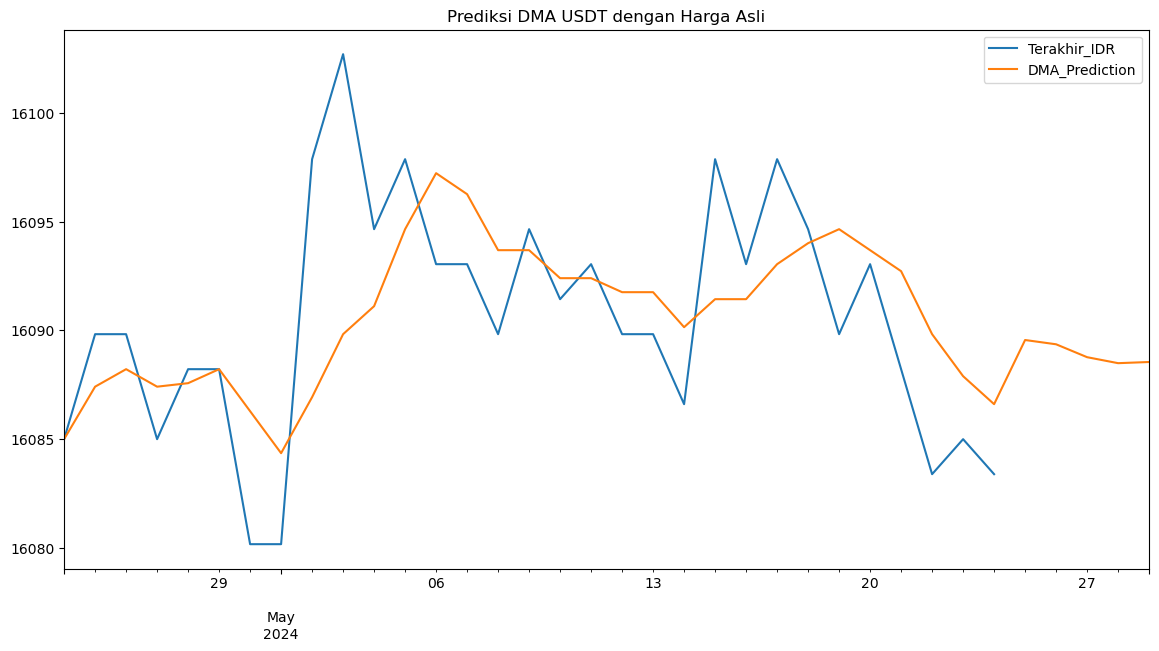

In [11]:
# Define short-term and long-term windows for DMA
short_window = 5
long_window = 20

# Calculate short-term and long-term moving averages
data['SMA'] = data['Terakhir_IDR'].rolling(window=short_window, min_periods=1).mean()
data['LMA'] = data['Terakhir_IDR'].rolling(window=long_window, min_periods=1).mean()

# Display the DMA data
display(data[['Terakhir_IDR', 'SMA', 'LMA']].head(20))

# Prediction with Double Moving Average (DMA)
data['DMA_Prediction'] = data['SMA']

# Extend DMA predictions for future dates dynamically
last_values = data['SMA'].dropna().values[-short_window:]
future_dates = [data.index[-1] + datetime.timedelta(days=i) for i in range(1, 6)]
future_sma = []

for i in range(5):
    new_sma = np.mean(np.append(last_values, [last_values[-1]])) # Simulate next SMA value
    future_sma.append(new_sma)
    last_values = np.append(last_values[1:], new_sma) # Shift the window

future_df_dma = pd.DataFrame({'DMA_Prediction': future_sma}, index=future_dates)

# Combine the original and future DMA predictions
dma_data = pd.concat([data, future_df_dma])

# Calculate differences and percentage differences for DMA
dma_data['Difference'] = dma_data['Terakhir_IDR'] - dma_data['DMA_Prediction']
dma_data['Percentage_Difference'] = dma_data['Difference'] / dma_data['Terakhir_IDR'] * 100

# Display the DMA predictions
display(dma_data.tail(10))

# Plot DMA predictions using pandas visualization
dma_data[['Terakhir_IDR', 'DMA_Prediction']].plot(figsize=(14, 7), title='Prediksi DMA USDT dengan Harga Asli')


In [12]:
# Prepare data for GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Terakhir_IDR']].fillna(method='ffill'))

# Create a function to prepare the dataset for GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X, Y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Print shapes of training and testing data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (8, 20, 1)
X_test shape: (2, 20, 1)
Y_train shape: (8,)
Y_test shape: (2,)


In [13]:
# Adjust the GRU model
model_path = 'GRU_model.h5'
if os.path.exists(model_path):
    model = load_model(model_path)
else:
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1), recurrent_activation='sigmoid'))
    model.add(GRU(50, recurrent_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)
    model.save(model_path)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Print some predictions
print(f"Train predictions: {train_predict[:5]}")
print(f"Test predictions: {test_predict[:5]}")


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train predictions: [[16089.417]
 [16088.665]
 [16090.472]
 [16090.36 ]
 [16091.2  ]]
Test predictions: [[16089.348]
 [16088.035]]


,Terakhir_IDR,Pembukaan_IDR,Tertinggi_IDR,Terendah_IDR,SMA,LMA,DMA_Prediction,GRU_Prediction,Difference,Percentage_Difference
2024-05-20,16093.039143,16089.820857,16101.084858,16089.820857,16093.682800,16093.039143,16093.682800,NaN,NaN,NaN
2024-05-21,16088.211714,16093.039143,16094.648286,16081.775142,16092.717314,16093.441429,16092.717314,NaN,NaN,NaN
2024-05-22,16083.384285,16088.211714,16091.430000,16083.384285,16089.820857,16092.717314,16089.820857,NaN,NaN,NaN
2024-05-23,16084.993428,16083.384285,16088.211714,16073.729427,16087.889885,16091.832286,16087.889885,NaN,NaN,NaN
2024-05-24,16083.384285,16084.993428,16089.820857,16080.165999,16086.602571,16091.269086,16086.602571,NaN,NaN,NaN
2024-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16087.226562,NaN,NaN
2024-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16087.607422,NaN,NaN
2024-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16087.833984,NaN,NaN
2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16087.912109,NaN,NaN
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16087.928711,NaN,NaN


<Axes: title={'center': 'Prediksi GRU USDT dengan Harga Asli'}>

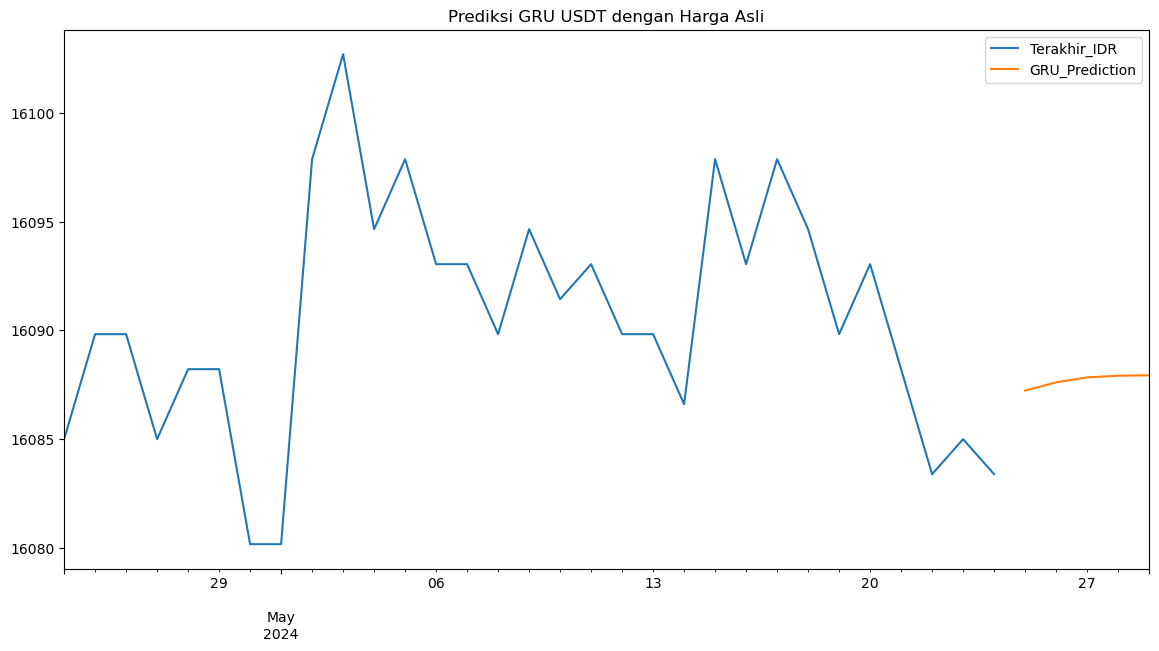

In [14]:
# Prepare data for future predictions
future_days = 5
future_predictions = []

last_sequence = scaled_data[-look_back:]
for _ in range(future_days):
    prediction = model.predict(np.reshape(last_sequence, (1, look_back, 1)))
    future_predictions.append(prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], prediction, axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Append future predictions to the data
future_df_gru = pd.DataFrame(future_predictions, index=future_dates, columns=['GRU_Prediction'])

# Combine the original and future data
gru_data = data.copy()
gru_data['GRU_Prediction'] = np.nan
gru_data = pd.concat([gru_data, future_df_gru])

# Calculate differences and percentage differences for GRU
gru_data['Difference'] = gru_data['Terakhir_IDR'] - gru_data['GRU_Prediction']
gru_data['Percentage_Difference'] = gru_data['Difference'] / gru_data['Terakhir_IDR'] * 100

# Display the GRU predictions
display(gru_data.tail(10))

# Plot GRU predictions using pandas visualization
gru_data[['Terakhir_IDR', 'GRU_Prediction']].plot(figsize=(14, 7), title='Prediksi GRU USDT dengan Harga Asli')


,Terakhir_IDR,Pembukaan_IDR,Tertinggi_IDR,Terendah_IDR,SMA,LMA,DMA_Prediction,Difference,Percentage_Difference,GRU_Prediction
2024-05-20,16093.039143,16089.820857,16101.084858,16089.820857,16093.682800,16093.039143,16093.682800,-0.643657,-0.004000,NaN
2024-05-21,16088.211714,16093.039143,16094.648286,16081.775142,16092.717314,16093.441429,16092.717314,-4.505600,-0.028006,NaN
2024-05-22,16083.384285,16088.211714,16091.430000,16083.384285,16089.820857,16092.717314,16089.820857,-6.436572,-0.040020,NaN
2024-05-23,16084.993428,16083.384285,16088.211714,16073.729427,16087.889885,16091.832286,16087.889885,-2.896457,-0.018007,NaN
2024-05-24,16083.384285,16084.993428,16089.820857,16080.165999,16086.602571,16091.269086,16086.602571,-3.218286,-0.020010,NaN
2024-05-25,NaN,NaN,NaN,NaN,NaN,NaN,16089.552666,NaN,NaN,16087.226562
2024-05-26,NaN,NaN,NaN,NaN,NaN,NaN,16089.355993,NaN,NaN,16087.607422
2024-05-27,NaN,NaN,NaN,NaN,NaN,NaN,16088.762994,NaN,NaN,16087.833984
2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN,16088.487851,NaN,NaN,16087.912109
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,16088.541655,NaN,NaN,16087.928711


<Axes: title={'center': 'Perbandingan Prediksi USDT'}>

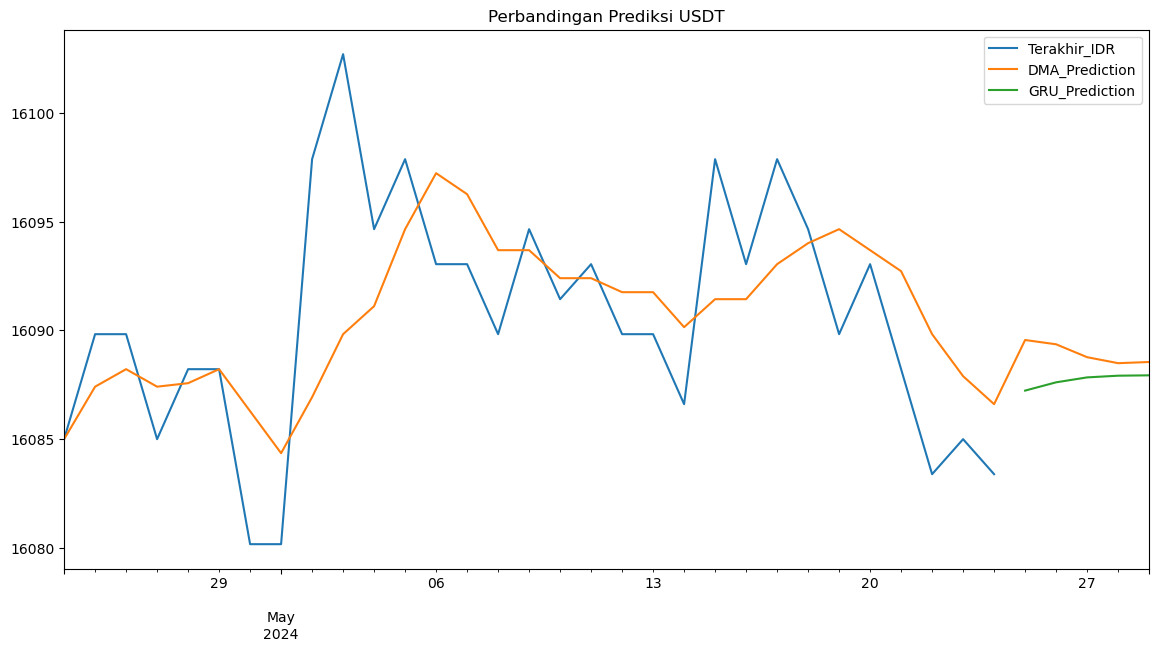

In [15]:
# Combine DMA and GRU predictions
combined_data = dma_data.copy()
combined_data['GRU_Prediction'] = gru_data['GRU_Prediction']

# Display the combined predictions
display(combined_data.tail(10))

# Plot combined predictions using pandas visualization
combined_data[['Terakhir_IDR', 'DMA_Prediction', 'GRU_Prediction']].plot(figsize=(14, 7), title='Perbandingan Prediksi USDT')


In [16]:
# Save combined predictions to Excel
combined_data.to_excel('Tether_Combined_Predictions.xlsx')
print("Combined predictions saved to 'Tether_Combined_Predictions.xlsx'")


Combined predictions saved to 'Tether_Combined_Predictions.xlsx'
